In [1]:
import os
import pickle
import joblib

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
gpu_number = 0 #### GPU number 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[gpu_number], 'GPU') 
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

In [106]:
# 데이터 read
df_train = pd.read_csv('./data/traffic_process/train.csv', parse_dates=['날짜', '시간'], dayfirst=True, infer_datetime_format=True)
df_false = pd.read_csv('./data/traffic_process/false.csv', parse_dates=['날짜', '시간'], dayfirst=True, infer_datetime_format=True)
df_train

,날짜,시간,총교통량,기온,강수량
0,182,0,9030,24.0,0.0
1,182,1,6469,24.0,0.0
2,182,2,5238,24.0,0.0
3,182,3,5834,23.0,0.0
4,182,4,11062,23.0,0.0
...,...,...,...,...,...
8755,181,19,35395,20.0,3.3
8756,181,20,27448,21.0,2.5
8757,181,21,24237,21.0,2.0
8758,181,22,18403,21.0,1.0


In [5]:
df_train.describe()

,총교통량,기온,강수량
count,8760.000000,8760.000000,8760.000000
mean,32627.669064,12.896792,0.190114
std,16125.413812,10.891627,1.380343
min,2377.000000,-13.900000,0.000000
25%,16409.500000,4.000000,0.000000
50%,40556.500000,14.000000,0.000000
75%,46282.000000,22.000000,0.000000
max,59837.000000,35.000000,43.900002


In [107]:
input_true = df_train.values
input_false = df_false.values

timesteps = 24
n_features = input_true.shape[1]

In [76]:
# 3차원화
def temporalize(X, timesteps):
	output_X = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
	return np.squeeze(np.array(output_X))

In [108]:
x_true = temporalize(input_true, timesteps)
x_false = temporalize(input_false, timesteps)
print(x_true.shape)
print(x_false.shape)

(8735, 24, 5)
(8735, 24, 5)


In [9]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

def deScale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.inverse_transform(X[i, :, :])
    return X

In [109]:
# 스케일링
scaler = StandardScaler().fit(flatten(x_true))

x_scale_true = scale(x_true, scaler).astype(float)
x_scale_false = scale(x_false, scaler).astype(float)

print(x_scale_true.shape)
print(x_scale_false.shape)

(8735, 24, 5)
(8735, 24, 5)


In [ ]:
# 스케일 범위 저장
joblib.dump(scaler, "./saved_model/traffic/scaler.pkl")

In [80]:
x_train, x_valid = train_test_split(x_scale_true, test_size=0.2)
print(x_train.shape)

(6988, 24, 5)


In [ ]:
lstm_ae = models.Sequential()
# Encoder
lstm_ae.add(layers.LSTM(128, input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(64, return_sequences=True))
lstm_ae.add(layers.LSTM(32, return_sequences=True))
lstm_ae.add(layers.LSTM(16, return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, return_sequences=True))
lstm_ae.add(layers.LSTM(32, return_sequences=True))
lstm_ae.add(layers.LSTM(64, return_sequences=True))
lstm_ae.add(layers.LSTM(128, return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

In [ ]:
# 학습된 모델 로딩
lstm_ae = tf.keras.models.load_model('./saved_model/traffic/v1/')
lstm_ae.summary()

In [96]:
# 하이퍼 파라미터
epochs = 20000
batch = 8192
lr = 0.001

In [97]:
# compile
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid, x_valid))

Epoch 1/20000
1/1 [==============================] - ETA: 0s - loss: 0.0717

In [28]:
# 학습 loss 기록 저장
with open('./saved_model/traffic/v1/trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [136]:
# 학습 loss 기록 저장
with open('./saved_model/traffic/v1/trainHistory', "rb") as file_pi:
    history = pickle.load(file_pi)

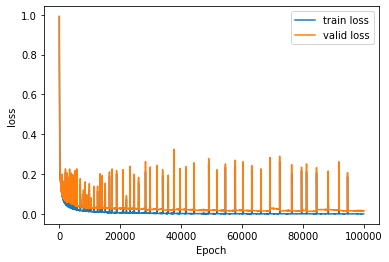

In [139]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [86]:
predict_false = lstm_ae.predict(x_scale_false)
print(predict_false.shape)

273/273 [==============================] - 1s 4ms/step
(8735, 24, 5)


273/273 [==============================] - 3s 4ms/step


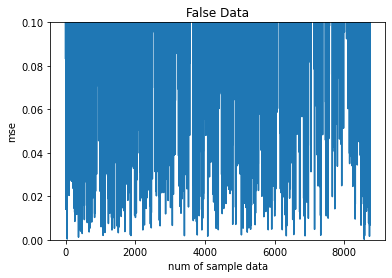

In [128]:
predict_false = lstm_ae.predict(x_scale_false)
mse_false = np.mean(np.power(flatten(x_scale_false) - flatten(predict_false), 2), axis=1)

plt.plot(np.linspace(0, len(mse_false)-1, len(mse_false)), mse_false)
plt.ylim([0, 0.1])
plt.title('False Data')
plt.ylabel('mse')
plt.xlabel('num of sample data')
plt.show()

55/55 [==============================] - 0s 4ms/step


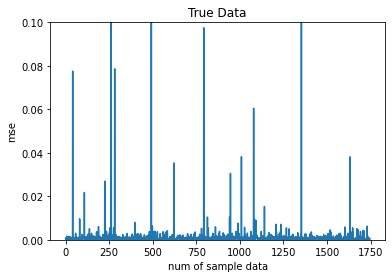

In [129]:
predict_valid = lstm_ae.predict(x_valid)
mse_valid = np.mean(np.power(flatten(x_valid) - flatten(predict_valid), 2), axis=1)

plt.plot(np.linspace(0, len(mse_valid)-1, len(mse_valid)), mse_valid)
plt.ylim([0, 0.1])
plt.title('True Data')
plt.ylabel('mse')
plt.xlabel('num of sample data')
plt.show()

In [133]:
# 특정 mse 기준으로 어떻게 데이터가 나뉘는지 확인
threshold_mse = 0.01

print(predict_false.shape)

(8735, 24, 5)


In [134]:
false_but_true = x_scale_false[mse_false <= threshold_mse].shape[0]
false_but_false = x_scale_false[mse_false > threshold_mse].shape[0]
true_but_true = x_valid[mse_valid <= threshold_mse].shape[0]
true_but_false = x_valid[mse_valid > threshold_mse].shape[0]
print(false_but_true)
print(false_but_false)
print(true_but_true)
print(true_but_false)

83
8652
1731
16


In [135]:
# 정밀도&재현율 계산
print("정밀도 : ", true_but_true/(true_but_true + false_but_true))
print("재현율 : ", true_but_true/(true_but_true + true_but_false))

정밀도 :  0.954244762954796
재현율 :  0.9908414424728106


In [29]:
# 모델 저장
lstm_ae.save('saved_model/traffic/v1')

INFO:tensorflow:Assets written to: saved_model/v1/assets


INFO:tensorflow:Assets written to: saved_model/v1/assets
